<a href="" target="_blank">
  <button style="background-color:#0072ce; color:white; padding:0.6em 1.2em; font-size:1rem; border:none; border-radius:6px; margin-top:1em;">
    🚀 Launch this notebook in JupyterLab
  </button>
</a>

### Introduction

In this section, we will discover how to search and access Sentienl-1 GRD data through EOPF Zarr samples services and how the SAR data is structured inside the groups and subgroups of a `.zarr` product. We will use some of the functions and methods used in the previous  [chapter](22_zarr_struct_S2L2A.ipynb) in order to understand the unique characteristics of Sentinel-1 GRD data.




### What we will learn


-  🗂️ How a Sentinel-1 GRD `.zarr` product is structered?
- 🔎 How to visualize some of the variables inside the `.zarr` product?
- 🚀 The practical meaning of these Sentinel-1 GRD variables

### Prerequisites

This tutorial uses a re-processed sample dataset from the [EOPF Sentinel Zarr Samples Service STAC API](https://stac.browser.user.eopf.eodc.eu/). We are using the Sentinel-1 GRD catalog that is available for direct access [here](https://stac.browser.user.eopf.eodc.eu/collections/sentinel-1-l1-grd). 

The selected `zarr` product that will be used is a Sentinel-1 GRD tile from the 08th of May 2017, from southern Italy area:
* File name: `S1A_IW_GRDH_1SDV_20170508T164830_20170508T164855_016493_01B54C_8604`.

It is uselful to install the extra dependencies from this environment. To do it, we just need to run the following command:
```bash
uv sync --all-extras
```

<hr>

#### Import libraries

In [207]:
import xarray as xr # The basic package to deal with data arrays
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
import sarsen as ss
#import xarray_sentinel # Works with arrays and it's specialized with Sentinel data
#import package 3 # Describe the functionality of package 3

#### Helper functions

##### `print_gen_structure`
This function helps us to retrieve and visualise the names for each of the stored groups inside a `.zarr` product. As an output, it will print a general overview of elements inside the `zarr`.

In [2]:
def print_gen_structure(node, indent=""):
    print(f"{indent}{node.name}")     #allows us access each node
    for child_name, child_node in node.children.items(): #loops inside the selected nodes to extract naming
        print_gen_structure(child_node, indent + "  ") # prints the name of the selected nodes

<hr>

## Sentinel-1 GRD structure

### Opening the Zarr groups and subgroups

Just like it was done for Sentinel-2 L2A, we are going to use the same functions to unwrap Sentinel-1 GRD `.zarr` products. `open_datatree()`and `open_dataset()` from `xarray` library are going to be great tools. Let's keep in mind the following:
- set `engine = "zarr"`, specifically designed for EOPF 
- `chunks = {}`, to keep the original chunking size defined in the `.zarr`file metadata

In [227]:
productID = "S1A_IW_GRDH_1SDV_20170508T164830_20170508T164855_016493_01B54C_8604"
url = f"https://objectstore.eodc.eu:2222/e05ab01a9d56408d82ac32d69a5aae2a:sample-data/tutorial_data/cpm_b716/{productID}.zarr"
dt = xr.open_datatree(url, engine='zarr', chunks={})
print_gen_structure(dt, indent="") # So we can visualize the data structure easily

None
  S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH
    conditions
      antenna_pattern
      attitude
      azimuth_fm_rate
      coordinate_conversion
      doppler_centroid
      gcp
      orbit
      reference_replica
      replica
      terrain_height
    measurements
    quality
      calibration
      noise
      noise_range
  S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VV
    conditions
      antenna_pattern
      attitude
      azimuth_fm_rate
      coordinate_conversion
      doppler_centroid
      gcp
      orbit
      reference_replica
      replica
      terrain_height
    measurements
    quality
      calibration
      noise
      noise_range


As we can see, Sentinel-1 GRD data is organized in a slightly different way. First of all, we notice that there are two main groups with the same subgroups. This is how the polarization information is structured: inside one single product we have access to two different polarizations. 

Each polarization group contains the `conditions`, `measurements` and `quality` subgroups. We can list all the groups for the VH polarization calling `.groups`.

In [230]:
vh = dt.S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH.groups
vh

('/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/measurements',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/quality',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/antenna_pattern',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/attitude',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/azimuth_fm_rate',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/coordinate_conversion',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/doppler_centroid',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/gcp',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/orbit',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/reference_replica',
 '/S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/replica',
 '/S01SIWGRD_20170508T164

### Checking information inside Zarr

Now that we know how to access each polarization group, we can check where some of the useful information is. Storing these kind of data in variables will helps to later plot some visuals results.

Because the actual SAR data is inside the `measurements` subgroup, we need to open this datase using `.open_dataset()` funtion.

In [165]:
measurements = xr.open_dataset(
    url,
    engine="zarr",
    group="S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/measurements",
    chunks={}
)
measurements

<xarray.Dataset> Size: 877MB
Dimensions:       (azimuth_time: 16694, ground_range: 26239)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 134kB 2017-05-08T16:48:30.467...
  * ground_range  (ground_range) float64 210kB 0.0 10.0 ... 2.624e+05 2.624e+05
    line          (azimuth_time) int64 134kB dask.array<chunksize=(16694,), meta=np.ndarray>
    pixel         (ground_range) int64 210kB dask.array<chunksize=(26239,), meta=np.ndarray>
Data variables:
    grd           (azimuth_time, ground_range) uint16 876MB dask.array<chunksize=(2557, 26239), meta=np.ndarray>

Antoher way to open a subgroup is converting the information showed on the data tree to a data set information, using `.to_dataset()` function.

In [166]:
measurements2 = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/measurements"].to_dataset()
if measurements == measurements2:
    print("Yes, it's the same!")

measurements2

Yes, it's the same!


<xarray.Dataset> Size: 877MB
Dimensions:       (azimuth_time: 16694, ground_range: 26239)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 134kB 2017-05-08T16:48:30.467...
  * ground_range  (ground_range) float64 210kB 0.0 10.0 ... 2.624e+05 2.624e+05
    line          (azimuth_time) int64 134kB dask.array<chunksize=(16694,), meta=np.ndarray>
    pixel         (ground_range) int64 210kB dask.array<chunksize=(26239,), meta=np.ndarray>
Data variables:
    grd           (azimuth_time, ground_range) uint16 876MB dask.array<chunksize=(2557, 26239), meta=np.ndarray>

We can do the same for other subgroups that contain SAR information that can be used for further processing steps. 

**calibration** subgroup inside `quality` is a very usefull subgroup to take a look at. Inside of it, among a few more, we'll find data concerning:
- `sigma_nought`or backscatter coefficient. It represents the strenght of the radar signal backscattered (or reflected back) from a target on earth's surface - expresses how much radar energy is reflected back toward the satellite from a unit area on the ground;
- `dn`, digital number and is the raw intensity data measured by the SAR sensor. It is unitless;

In [253]:
calibration = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/quality/calibration"].to_dataset()
calibration

<xarray.Dataset> Size: 292kB
Dimensions:       (azimuth_time: 27, ground_range: 657)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 216B 2017-05-08T16:48:30.4679...
  * ground_range  (ground_range) float64 5kB 0.0 6.677e+06 ... 4.38e+09
    line          (azimuth_time) uint32 108B dask.array<chunksize=(27,), meta=np.ndarray>
    pixel         (ground_range) uint32 3kB dask.array<chunksize=(657,), meta=np.ndarray>
Data variables:
    beta_nought   (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>
    dn            (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>
    gamma         (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>
    sigma_nought  (azimuth_time, ground_range) float32 71kB dask.array<chunksize=(27, 657), meta=np.ndarray>

**gcp** subgroup inside `conditions` it is also very important for the proecessing workflow on Sentinel-1 images. GCP stands for ground control points and are known and precise geolocated references on earth's surface. They can be used to later georeference our grd image. 

In [246]:
gcp = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/gcp"].to_dataset()
gcp

<xarray.Dataset> Size: 12kB
Dimensions:               (azimuth_time: 10, ground_range: 21)
Coordinates:
  * azimuth_time          (azimuth_time) datetime64[ns] 80B 2017-05-08T16:48:...
  * ground_range          (ground_range) float64 168B 0.0 ... 2.624e+05
    line                  (azimuth_time) uint32 40B dask.array<chunksize=(10,), meta=np.ndarray>
    pixel                 (ground_range) uint32 84B dask.array<chunksize=(21,), meta=np.ndarray>
Data variables:
    azimuth_time_gcp      (azimuth_time, ground_range) datetime64[ns] 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    elevation_angle       (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    height                (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    incidence_angle       (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    latitude              (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    longitude             (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    slant_range_time_gcp  (azimuth_time, ground_range) float64 2kB dask.array<chunksize=(10, 21), meta=np.ndarray>

**orbit** subgroup inside `conditions` is a variable that reflects how the orbital trajectory of the sattelite behaved during the flight. 

In [169]:
orbit = dt["S01SIWGRD_20170508T164830_0025_A094_8604_01B54C_VH/conditions/orbit"].to_dataset()
orbit

<xarray.Dataset> Size: 952B
Dimensions:       (azimuth_time: 17, axis: 3)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 136B 2017-05-08T16:47:24.0541...
Dimensions without coordinates: axis
Data variables:
    position      (azimuth_time, axis) float64 408B dask.array<chunksize=(17, 3), meta=np.ndarray>
    velocity      (azimuth_time, axis) float64 408B dask.array<chunksize=(17, 3), meta=np.ndarray>

In [276]:
orbit_located = orbit.assign_coords(
    {"latitude": gcp.latitude, "longitude": gcp.longitude}
)
orbit_located

<xarray.Dataset> Size: 7kB
Dimensions:       (azimuth_time: 17, axis: 3, ground_range: 21)
Coordinates:
  * azimuth_time  (azimuth_time) datetime64[ns] 136B 2017-05-08T16:47:24.0541...
  * ground_range  (ground_range) float64 168B 0.0 1.312e+04 ... 2.624e+05
    line          (azimuth_time) float64 136B dask.array<chunksize=(10,), meta=np.ndarray>
    pixel         (ground_range) uint32 84B dask.array<chunksize=(21,), meta=np.ndarray>
    latitude      (azimuth_time, ground_range) float64 3kB dask.array<chunksize=(10, 21), meta=np.ndarray>
    longitude     (azimuth_time, ground_range) float64 3kB dask.array<chunksize=(10, 21), meta=np.ndarray>
Dimensions without coordinates: axis
Data variables:
    position      (azimuth_time, axis) float64 408B dask.array<chunksize=(17, 3), meta=np.ndarray>
    velocity      (azimuth_time, axis) float64 408B dask.array<chunksize=(17, 3), meta=np.ndarray>

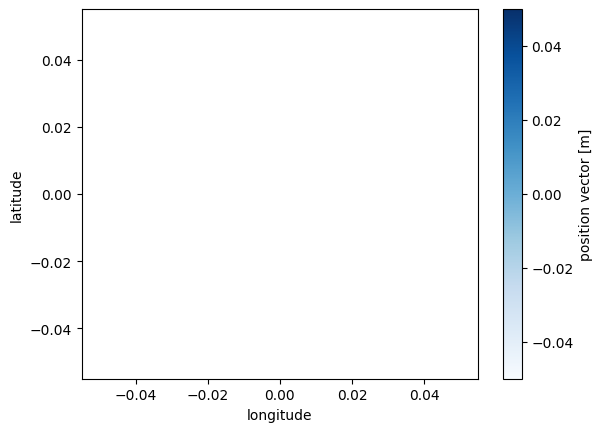

In [281]:
orbit_located.plot.scatter(y="latitude", x="longitude", hue="position", cmap="Blues")
plt.show()

## Visualizing SAR products

### GRD

A GRD product shows us the amplitude of SAR image. The amplitude reflects the intensity of the radar backscatter, which is the same thing as saying that the amplitude shows how much energy is rfelected or absorved by the surface.

Sentinel-1 GRD data represents the detected radar signal amplitude in a raw unitless value called **sigma nought**

In [239]:
grd = measurements.grd
grd_decimated = grd.isel(
    azimuth_time=slice(None, None, 10), ground_range=slice(None, None, 10)
)

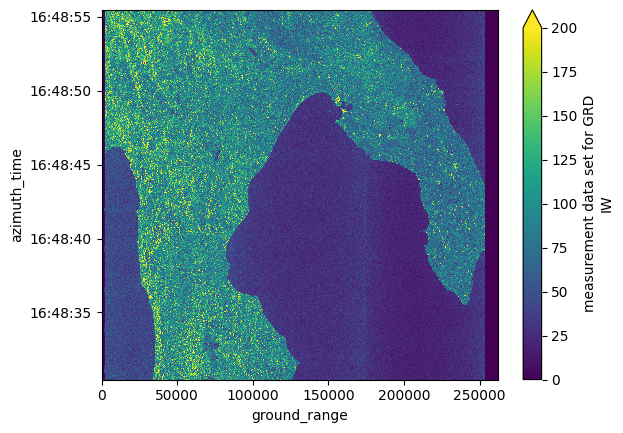

In [265]:
grd_decimated.plot(vmax=200)
plt.show()

### Sigma Nought

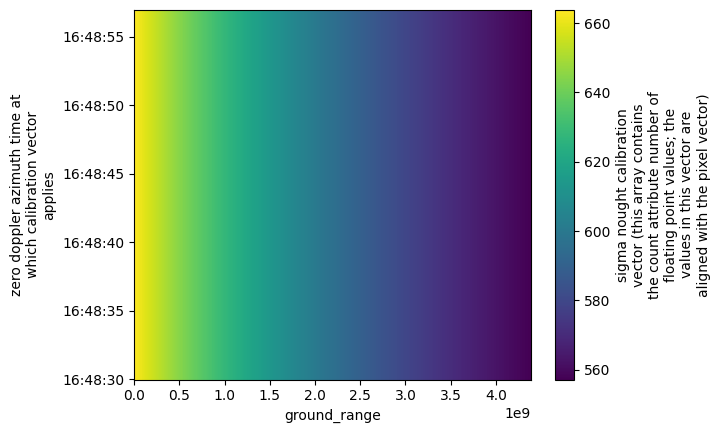

In [243]:
calibration.sigma_nought.plot()
plt.show()

### DN (digital number)

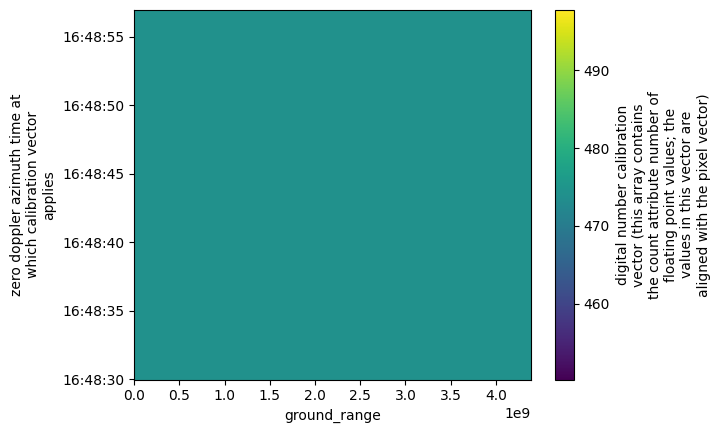

In [263]:
calibration.dn.plot()
plt.show()

And the reason why the graphic shown above only displays a specific color range is because the digital number is always the same:

In [189]:
calibration.dn.values[1][1].item()

474.0

### GCP

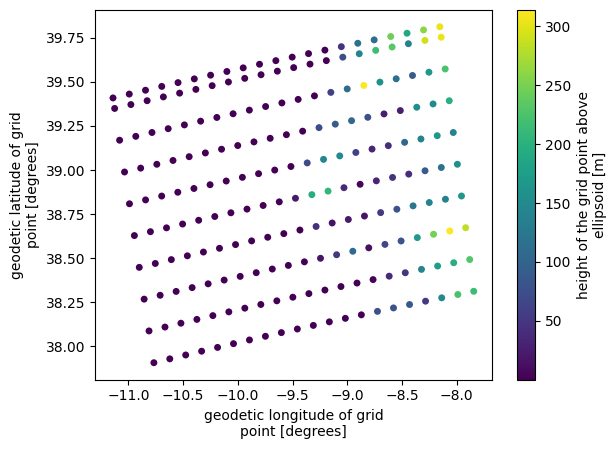

In [191]:
gcp.plot.scatter(x="longitude", y="latitude", hue="height")
plt.show()

### Orbit

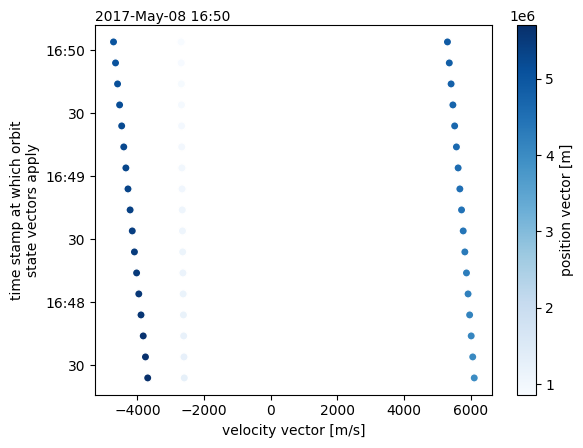

In [238]:
orbit.plot.scatter(y="azimuth_time", x="velocity", hue="position", cmap="Blues")
plt.show()

In [247]:
gcp_iterpolated = gcp.interp_like(grd_decimated)
gcp_iterpolated

<xarray.Dataset> Size: 210MB
Dimensions:               (azimuth_time: 1670, ground_range: 2624)
Coordinates:
    line                  (azimuth_time) float64 13kB dask.array<chunksize=(1670,), meta=np.ndarray>
    pixel                 (ground_range) float64 21kB dask.array<chunksize=(2624,), meta=np.ndarray>
  * azimuth_time          (azimuth_time) datetime64[ns] 13kB 2017-05-08T16:48...
  * ground_range          (ground_range) float64 21kB 0.0 100.0 ... 2.623e+05
Data variables:
    elevation_angle       (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    height                (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    incidence_angle       (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    latitude              (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    longitude             (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>
    slant_range_time_gcp  (azimuth_time, ground_range) float64 35MB dask.array<chunksize=(1670, 2624), meta=np.ndarray>

<hr>

## 💪 Now it is your turn

--> *This section contains an engaging part with some exercises or tasks for the learner.*

*Some ideas:*
* *Ask the learner to repeat the workflow with a different dataset*
* *Ask the learner to modify the area of interest.*
* *Ask the learner to reflect and test their level of understanding / comprehension*

Example: 

The following exercises will help you master the STAC API and understand how to find the data you need.

### Task 1: Explore Your Own Area of Interest
* Go to http://bboxfinder.com/ and select an area of interest (AOI) (e.g. your hometown, a research site, etc.)
* Copy the bounding box coordinates of your area of interest
* Change the provided code above to search for data over your AOI

### Task 2: Temporal Analysis
* Compare data availability across different years for the Sentinel-2 L-2A Collection.
* Search for items in year 2022
* Repeat the search for year 2024

### Task 3: Explore the SAR Mission and combine multiple criteria
* Do the same for a different Collection for example the Sentinel-1 Level-1 GRD, e.g. you can use the ID sentinel-1-l1-grd
* How many assets are available for the year 2024?



## Conclusion

--> *This section summarises the objectives of the notebook, what a learner learned and what possible conclusions / results were obtained.*

## What's next?

--> *In one or two sentences, describe what awaits the learner in the next chapter and include a link to the next chapter.*